In [1]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Notes
# use rbf for cyber

In [20]:
# import data 
cds = pd.read_csv('credit_data_simulate.csv')
crsd = pd.read_csv('credit_risk_small_data.csv')
cyber = pd.read_csv('cybersecurity_data.csv')


datasets = [cds, crsd, cyber]

In [21]:
# print shape of data and nas
for dataset in datasets:
    print(dataset.shape)

(1670, 7)
(2405, 11)
(510, 42)


In [45]:
class Bagging:
    def __init__(self, datasets):
        self.datasets = datasets

    def split_data(self, dataset):
        X = dataset.drop('target', axis=1)
        y = dataset['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
        train = pd.concat([X_train, y_train], axis=1)
        test = pd.concat([X_test, y_test], axis=1)
        return train, test

    def create_subsets(self, train_data):
        half_size = int(0.5 * len(train_data))
        training_1 = train_data.sample(n=half_size, random_state=42)
        training_2 = train_data.sample(n=half_size, random_state=43)
        training_3 = train_data.sample(n=half_size, random_state=44)
        return training_1, training_2, training_3

    def scale_data(self, df):
        from sklearn.preprocessing import MaxAbsScaler
        scaler = MaxAbsScaler()
        df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
        return df

    def do_bagging(self, dataset):
        dataset = dataset.dropna()
        dataset = self.scale_data(dataset)
        X = dataset.drop('target', axis=1)
        y = dataset['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        model = BaggingClassifier(estimator=SVC(kernel='rbf'), n_estimators=10, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        return y_test, y_pred, model

    def do_svm(self, train_data, test_data):
        X_train = train_data.drop('target', axis=1)
        y_train = train_data['target']
        X_test = test_data.drop('target', axis=1)
        y_test = test_data['target']
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

        # Set n_neighbors to min number of samples in the minority class - 1 (or at least 1)
        n_neighbors = min(y_train.value_counts().min() - 1, 5)  # 5 is the default n_neighbors in SMOTE
        if n_neighbors < 1:
            n_neighbors = 1

        smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        model = SVC(kernel='rbf', random_state=42, class_weight='balanced')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        return y_test, y_pred

    def voting(self, y_pred_1, y_pred_2, y_pred_3):
        final_pred = []
        for i in range(len(y_pred_1)):
            votes = [y_pred_1[i], y_pred_2[i], y_pred_3[i]]
            final_pred.append(max(set(votes), key=votes.count))
        return final_pred

    def plot_confusion_matrix(self, y_test, y_pred):
        cm = confusion_matrix(y_test, y_pred)
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               title='Confusion Matrix',
               ylabel='True label',
               xlabel='Predicted label')
        plt.show()

    def run_experiments(self):
        for dataset in self.datasets:
            train, test = self.split_data(dataset)
            training_1, training_2, training_3 = self.create_subsets(train)

            y_test, y_pred_1 = self.do_svm(training_1, test)
            y_test, y_pred_2 = self.do_svm(training_2, test)
            y_test, y_pred_3 = self.do_svm(training_3, test)

            final_pred = self.voting(y_pred_1, y_pred_2, y_pred_3)
            print(classification_report(y_test, final_pred))
            self.plot_confusion_matrix(y_test, final_pred)
            y_test, y_pred, model = self.do_bagging(dataset)
            print(classification_report(y_test, y_pred))
            self.plot_confusion_matrix(y_test, y_pred)
            print('---')

    def data_analysis(self):
        for dataset in self.datasets:
            print(dataset['target'].value_counts())
            # print(dataset.describe())
            print('---')



(668, 6) (668,) (334, 6) (334,)
(668, 6) (668,) (334, 6) (334,)
(668, 6) (668,) (334, 6) (334,)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00       308

    accuracy                           1.00       334
   macro avg       1.00      1.00      1.00       334
weighted avg       1.00      1.00      1.00       334



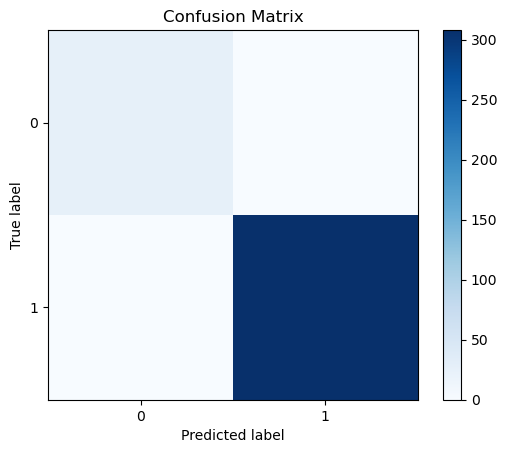

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        27
         1.0       1.00      1.00      1.00       307

    accuracy                           1.00       334
   macro avg       1.00      1.00      1.00       334
weighted avg       1.00      1.00      1.00       334



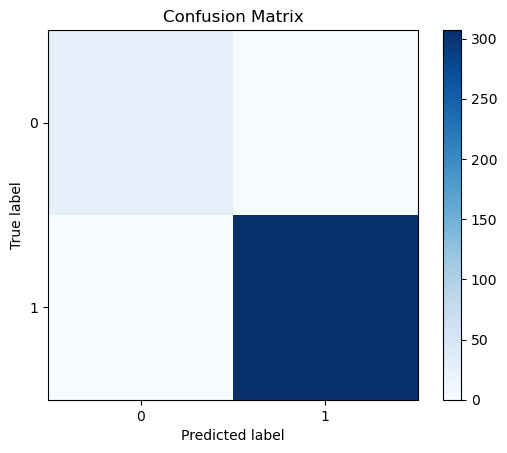

---
(962, 10) (962,) (481, 10) (481,)
(962, 10) (962,) (481, 10) (481,)
(962, 10) (962,) (481, 10) (481,)
              precision    recall  f1-score   support

           0       0.95      0.36      0.52       450
           1       0.07      0.71      0.13        31

    accuracy                           0.38       481
   macro avg       0.51      0.53      0.32       481
weighted avg       0.89      0.38      0.49       481



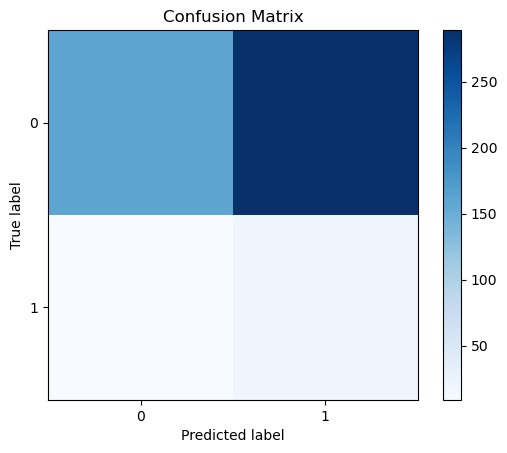

              precision    recall  f1-score   support

         0.0       0.94      0.76      0.84       444
         1.0       0.14      0.46      0.21        37

    accuracy                           0.74       481
   macro avg       0.54      0.61      0.53       481
weighted avg       0.88      0.74      0.79       481



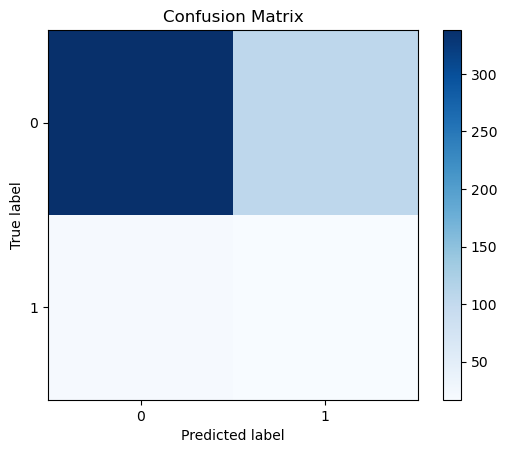

---
(204, 41) (204,) (102, 41) (102,)
(204, 41) (204,) (102, 41) (102,)
(204, 41) (204,) (102, 41) (102,)
              precision    recall  f1-score   support

          -1       0.97      0.59      0.73        99
           1       0.02      0.33      0.04         3

    accuracy                           0.58       102
   macro avg       0.50      0.46      0.39       102
weighted avg       0.94      0.58      0.71       102



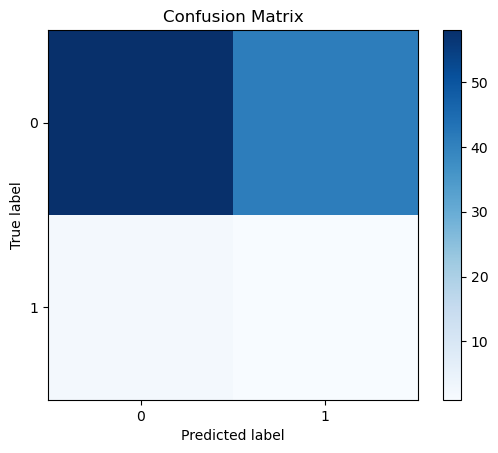

              precision    recall  f1-score   support

        -1.0       1.00      0.87      0.93        98
         1.0       0.24      1.00      0.38         4

    accuracy                           0.87       102
   macro avg       0.62      0.93      0.65       102
weighted avg       0.97      0.87      0.91       102



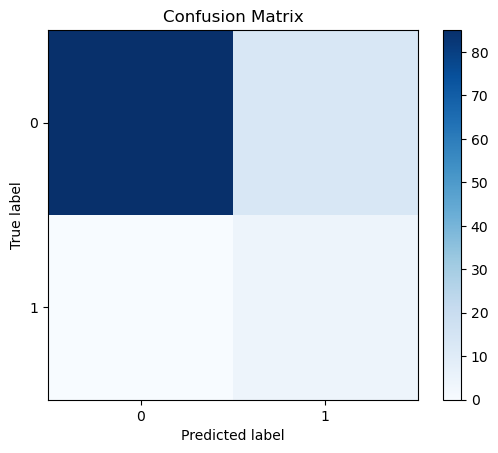

---


In [46]:
bagging_instance = Bagging(datasets)

bagging_instance.run_experiments()

In [41]:
bagging_instance.data_analysis()

1    1540
0     130
Name: target, dtype: int64
---
0    2248
1     157
Name: target, dtype: int64
---
-1    493
 1     17
Name: target, dtype: int64
---
